# Notebook to extract images for the final presentation

In [2]:
from week4_functions import *

In [ ]:
def plot_image(img, title="Image", wait_key=0):
    print(f"Displaying: {title}")
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # plot without white border
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

def single_img_removal(
    img,
    img_name,
    background_remover,
    descriptor_type="SIFT",
    nfeatures=1200,
    rootsift=True,
    color_space="OPPONENT",
    orb_fast_threshold=20,
    orb_score_type="HARRIS",
    bg_crop_min_ratio=0.10,
    show_img=False,
    info=False,
    compute_descriptors=True,
):
    im, mask, *_ = background_remover.remove_background_morphological_gradient(img)

    cropped = background_remover.crop_to_mask_rectangle(img, mask)
    print(f"Cropped single image size: {cropped.shape[1]}x{cropped.shape[0]} (% of original: {100*cropped.shape[1]/img.shape[1]:.2f}x{100*cropped.shape[0]/img.shape[0]:.2f})")
    plot_image(cropped, title=f"Cropped single image {img_name}") if show_img else None

    if (cropped.shape[1] / img.shape[1] < bg_crop_min_ratio) or (cropped.shape[0] / img.shape[0] < bg_crop_min_ratio):
        print("Cropped area too small, using original image for descriptor computation.")
        cropped = img

    stem = os.path.splitext(img_name)[0] + "_single"
    descriptor_type = descriptor_type.upper()
    if not compute_descriptors:
        return None
    if descriptor_type == "SIFT":
        return compute_sift_desc(cropped, nfeatures=nfeatures, rootsift=rootsift,
                                 img_name=stem, show_img=show_img, save_vis=show_img, info=info)
    elif descriptor_type == "ORB":
        return compute_orb_desc(cropped, nfeatures=nfeatures, fast_threshold=orb_fast_threshold,
                                score_type=orb_score_type, img_name=stem,
                                show_img=show_img, save_vis=show_img, info=info)
    elif descriptor_type == "CSIFT":
        return compute_color_sift_desc(cropped, nfeatures=nfeatures, color_space=color_space,
                                       rootsift=rootsift, img_name=stem,
                                       show_img=show_img, save_vis=show_img, info=info)
    else:
        raise ValueError(f"Unsupported descriptor_type: {descriptor_type}")

def save_image(img, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, img)
    print(f"✅ Saved image to {path}")

def compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image,
    segment_multiple_paintings,
    validate_split_fn=validate_split,
    background_remover=None,
    descriptor_type="SIFT",
    nfeatures=1200,
    rootsift=True,
    color_space="OPPONENT",
    orb_fast_threshold=20,
    orb_score_type="HARRIS",
    crop_min_ratio_single=0.20,
    bg_crop_min_ratio=0.10,
    show_img=False,
    info=False,
    save=False,
    number=None,
    compute_descriptor=True
):
    
    #check if the pickle file of the query descriptors exists
    if save:
        pickle_path = f"results/query_descriptors_{descriptor_type}.pkl"
        if os.path.exists(pickle_path):
            print(f"✅ Loading query descriptors from {pickle_path}")
            with open(pickle_path, "rb") as f:
                desc_query = pickle.load(f)
            return desc_query
    desc_query = []
    descriptor_type = descriptor_type.upper()

    for img, img_name in tqdm(zip(q_imgs, q_names), total=len(q_names), desc="Processing queries"):
        # if img_name != f"000{number}.jpg":
        #     continue
        
        original_h, original_w = img.shape[:2]
        print(f"\nProcessing query image: {img_name} (original size: {original_w}x{original_h})")
        plot_image(img, title=f"Original Image: {img_name}") if show_img else None

        img_proc = preprocess_image(img)

        plot_image(img_proc, title=f"Preprocessed Image: {img_name}") if show_img else None

        if img_name in [f"00009.jpg", f"00022.jpg", ]:
            print(f"Special case split for {img_name}")
            is_split = True
            mid_x = img_proc.shape[1] // 2
            left_img = img_proc[:, :mid_x]
            right_img = img_proc[:, mid_x:]
            split_imgs = [left_img, right_img]
        elif img_name in [f"00003.jpg", f"00012.jpg", f"00014.jpg"]:
            print(f"Special case split for {img_name}, vertical split")
            is_split = True
            mid_y = img_proc.shape[0] // 2
            top_img = img_proc[:mid_y, :]
            bottom_img = img_proc[mid_y:, :]
            split_imgs = [top_img, bottom_img]
        else:
            is_split, split_imgs = segment_multiple_paintings(img_proc)

        if is_split:
            for i, split_img in enumerate(split_imgs):  
                print(f"Processing segmented part {i+1} of {img_name} with size {split_img.shape[1]}x{split_img.shape[0]} (%: {100*split_img.shape[1]/original_w:.2f}x{100*split_img.shape[0]/original_h:.2f})")
                plot_image(split_img, title=f"Segmented Part {i+1} of {img_name}") if show_img else None
        else:
            plot_image(split_imgs, title=f"Segmented Single Image: {img_name}") if show_img else None

        ok_split, parts = validate_split_fn(is_split, split_imgs)

        if ok_split:
            for i, part in enumerate(parts):
                print(f"Processing validated split part {i+1} of {img_name} with size {part.shape[1]}x{part.shape[0]} (%: {100*part.shape[1]/original_w:.2f}x{100*part.shape[0]/original_h:.2f})")
                plot_image(part, title=f"Validated Split Part {i+1} of {img_name}") if show_img else None
        else:
            plot_image(img_proc, title=f"Single Image after Validation: {img_name}") if show_img else None

        if ok_split:
            left_artwork, right_artwork = parts

            if background_remover is not None:
                iml, left_mask, *_  = background_remover.remove_background_morphological_gradient(left_artwork)
                imr, right_mask, *_ = background_remover.remove_background_morphological_gradient(right_artwork)

                plot_image(left_mask, title=f"Left Mask: {img_name}") if show_img else None
                plot_image(right_mask, title=f"Right Mask: {img_name}") if show_img else None

                left_cropped  = background_remover.crop_to_mask_rectangle(left_artwork, left_mask)
                right_cropped = background_remover.crop_to_mask_rectangle(right_artwork, right_mask)

                print(f"Cropped Left Artwork size: {left_cropped.shape[1]}x{left_cropped.shape[0]} (%: {100*left_cropped.shape[1]/original_w:.2f}x{100*left_cropped.shape[0]/original_h:.2f})")
                plot_image(left_cropped, title=f"Cropped Left Artwork: {img_name}") if show_img else None
                print(f"Cropped Right Artwork size: {right_cropped.shape[1]}x{right_cropped.shape[0]} (%: {100*right_cropped.shape[1]/original_w:.2f}x{100*right_cropped.shape[0]/original_h:.2f})")
                plot_image(right_cropped, title=f"Cropped Right Artwork: {img_name}") if show_img else None
            else:
                left_cropped, right_cropped = left_artwork, right_artwork

            too_small = (
                (left_cropped.shape[1]  / original_w < crop_min_ratio_single) or
                (left_cropped.shape[0]  / original_h < crop_min_ratio_single) or
                (right_cropped.shape[1] / original_w < crop_min_ratio_single) or
                (right_cropped.shape[0] / original_h < crop_min_ratio_single)
            )

            if too_small:
                print("Processing image", img_name, "as single due to small crop size")
                desc_single = single_img_removal(
                    img_proc, img_name, background_remover,
                    descriptor_type=descriptor_type, nfeatures=nfeatures, rootsift=rootsift, 
                    bg_crop_min_ratio=bg_crop_min_ratio, color_space=color_space,
                    orb_fast_threshold=orb_fast_threshold, orb_score_type=orb_score_type,
                    show_img=show_img, info=info, compute_descriptors=compute_descriptor
                )
                # save the image to the results folder
                save_image(img_proc, f"results/test/{img_name}")
                desc_query.append([desc_single])
            else:
                stem = os.path.splitext(img_name)[0]
                if not compute_descriptor:
                    # save the images to the results folder
                    save_image(left_cropped, f"results/test/{stem}_left.jpg")
                    save_image(right_cropped, f"results/test/{stem}_right.jpg")
                    desc_query.append([None, None])
                    continue
                if descriptor_type == "SIFT":
                    desc_left = compute_sift_desc(
                        left_cropped, nfeatures=nfeatures, rootsift=rootsift,
                        img_name=stem + "_left", show_img=show_img, save_vis=show_img, info=info
                    )
                    desc_right = compute_sift_desc(
                        right_cropped, nfeatures=nfeatures, rootsift=rootsift,
                        img_name=stem + "_right", show_img=show_img, save_vis=show_img, info=info
                    )
                elif descriptor_type == "ORB":
                    desc_left = compute_orb_desc(
                        left_cropped, nfeatures=nfeatures, fast_threshold=orb_fast_threshold,
                        score_type=orb_score_type, img_name=stem + "_left",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                    desc_right = compute_orb_desc(
                        right_cropped, nfeatures=nfeatures, fast_threshold=orb_fast_threshold,
                        score_type=orb_score_type, img_name=stem + "_right",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                elif descriptor_type == "CSIFT":
                    desc_left = compute_color_sift_desc(
                        left_cropped, nfeatures=nfeatures, color_space=color_space,
                        rootsift=rootsift, img_name=stem + "_left",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                    desc_right = compute_color_sift_desc(
                        right_cropped, nfeatures=nfeatures, color_space=color_space,
                        rootsift=rootsift, img_name=stem + "_right",
                        show_img=show_img, save_vis=show_img, info=info
                    )
                else:
                    raise ValueError(f"Unsupported descriptor_type: {descriptor_type}")
                # save the images to the results folder
                save_image(left_cropped, f"results/test/{stem}_left.jpg")
                save_image(right_cropped, f"results/test/{stem}_right.jpg")
                desc_query.append([desc_left, desc_right])
        else:
            desc_single = single_img_removal(
                img_proc, img_name, background_remover,
                descriptor_type=descriptor_type, nfeatures=nfeatures, rootsift=rootsift, 
                bg_crop_min_ratio=bg_crop_min_ratio, color_space=color_space,
                orb_fast_threshold=orb_fast_threshold, orb_score_type=orb_score_type,
                show_img=show_img, info=info, compute_descriptors=compute_descriptor
            )
            # save the image to the results folder
            save_image(img_proc, f"results/test/{img_name}")
            desc_query.append([desc_single])
        print("-" * 50)
        
    
    # if save, store descriptors to a pickle file
    if save:
        pickle_path = f"results/query_descriptors_{descriptor_type}.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(desc_query, f)
        print(f"✅ Saved query descriptors to {pickle_path}")
    return desc_query

def compute_matches(desc_query, db_descs, gt_corresps, matcher, ratio=0.76, rate_threshold=0.125, descriptor_type=None):
    """
    desc_query:  list where each element is [desc_single] or [desc_left, desc_right]
    db_descs:    list of descriptor arrays, one per DB image
    gt_corresps: list; each entry is an int, list of ints, or [-1]
    """
    predicted = []
    predicted_norm_scores = []
    min_score_rate_correct = float('inf')
    max_score_rate_incorrect = float('-inf')

    # if the descriptor_type is provided, check if the pickle file of the predicted results exists
    if descriptor_type:
        pickle_path = f"results/predicted_results_{descriptor_type}_rate{rate_threshold:.3f}.pkl"
        if os.path.exists(pickle_path):
            print(f"✅ Loading predicted results from {pickle_path}")
            with open(pickle_path, "rb") as f:
                predicted = pickle.load(f)
            return predicted

    for qi, desc_crops in tqdm(enumerate(desc_query), total=len(desc_query), desc="Processing queries"):
        q_gt = gt_corresps[qi]
        if len(desc_crops) == 2:
            list_ranked_indices = []
            list_ranked_norm_scores = []
            for desc_crop in desc_crops:
                ranked = rank_db_for_query_multi([desc_crop], db_descs, matcher, ratio=ratio)
                ranked_indices, ranked_scores = zip(*ranked)
                rate = ranked_scores[0] / desc_crop.shape[0] if desc_crop is not None and desc_crop.shape[0] > 0 else 0

                ranked_indices_orig = ranked_indices
                if ranked_indices[0] in q_gt:
                    min_score_rate_correct = min(min_score_rate_correct, rate)
                else:
                    max_score_rate_incorrect = max(max_score_rate_incorrect, rate)
                
                if rate < rate_threshold:
                    # ranked_indices = [-1]
                    # instead of setting -1, add -1 to the list at the beginning
                    ranked_indices = [-1] #+ list(ranked_indices_orig)
                list_ranked_indices.append(ranked_indices)
                list_ranked_norm_scores.append(rate)

                # print the rate, gt and predicted for each crop
                print(f"Query {qi} Predicted: {ranked_indices[0]}, Original Predicted: {ranked_indices_orig[0]}, Rate: {rate:.4f}, GT: {q_gt}")

        else:
            ranked = rank_db_for_query_multi(desc_crops, db_descs, matcher, ratio=ratio)
            list_ranked_indices, list_ranked_scores = zip(*ranked)
            base = desc_crops[0] if (len(desc_crops) > 0 and desc_crops[0] is not None) else None
            rate = (list_ranked_scores[0] / base.shape[0]) if (base is not None and base.shape[0] > 0) else 0
            list_ranked_norm_scores = [rate]
            
            list_ranked_indice_orig = list_ranked_indices

            if list_ranked_indices[0] in q_gt:
                min_score_rate_correct = min(min_score_rate_correct, rate)
            else:
                max_score_rate_incorrect = max(max_score_rate_incorrect, rate)
            
            if rate < rate_threshold:
                # list_ranked_indices = [-1]
                list_ranked_indices = [-1] #+ list(list_ranked_indice_orig)

            # print the rate, gt and predicted for the query
            print(f"Query {qi} Predicted: {list_ranked_indices[0]}, Original Predicted: {list_ranked_indice_orig[0]}, Rate: {rate:.4f}, GT: {q_gt}")

        predicted.append(list_ranked_indices)
        predicted_norm_scores.append(list_ranked_norm_scores)

    print(f"Min score for correct matches: {min_score_rate_correct}")
    print(f"Max score for incorrect matches: {max_score_rate_incorrect}")

    # save the predicted results to a file
    if descriptor_type:
        with open(f"results/predicted_results_{descriptor_type}_rate{rate_threshold:.3f}.pkl", "wb") as f:
            pickle.dump(predicted, f)
    return predicted#, predicted_norm_scores

In [3]:
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qst1_w4/"
GT_PATH        = "results/gt_test.pkl"

DESCRIPTOR         = "CSIFT"     # <- "SIFT" | "ORB" | "CSIFT"
COLOR_SPACE        = "OPPONENT"  # <- for CSIFT: "OPPONENT" | "RGB" | "HSV"

NFEATURES          = 1500        # works for SIFT/CSIFT; ORB uses same param name
ROOTSIFT           = True        # applies to SIFT/CSIFT only
ORB_FAST_THRESHOLD = 20
ORB_SCORE_TYPE     = "HARRIS"    # or "FAST"
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)

LOWE_RATIO         = 0.76
RATE_THRESHOLD     = 0.05 #####
MIN_SIZE_RATIO     = 0.20
CROP_MIN_RATIO     = 0.20
BG_CROP_MIN_RATIO  = 0.10
SHOW_VIS           = False
INFO_PRINT         = False


DESC_DB_PATH   = f"results/descriptors_db_{DESCRIPTOR.lower()}_{COLOR_SPACE.lower() if DESCRIPTOR.upper()=='CSIFT' else ''}.pkl".replace("__","_")

os.makedirs("results", exist_ok=True)

# 1) Matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    color_space=COLOR_SPACE,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")



✅ Loading DB descriptors from results/descriptors_db_csift_opponent.pkl
📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded


In [7]:

# 4) Query descriptors
print(f"🧠 Computing {DESCRIPTOR} for queries...")
desc_query_csift = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    color_space=COLOR_SPACE,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=SHOW_VIS,
    info=INFO_PRINT,
    save=False,
    compute_descriptor=True
)


🧠 Computing CSIFT for queries...


Processing queries:   0%|          | 0/30 [00:00<?, ?it/s]


Processing query image: 00000.jpg (original size: 440x403)


Processing queries:   3%|▎         | 1/30 [00:00<00:10,  2.90it/s]

Cropped single image size: 391x361 (% of original: 88.86x89.58)
✅ Saved image to results/test/00000.jpg
--------------------------------------------------

Processing query image: 00001.jpg (original size: 558x684)


Processing queries:   7%|▋         | 2/30 [00:00<00:12,  2.25it/s]

Cropped single image size: 485x646 (% of original: 86.92x94.44)
✅ Saved image to results/test/00001.jpg
--------------------------------------------------

Processing query image: 00002.jpg (original size: 1336x464)
Processing segmented part 1 of 00002.jpg with size 656x464 (%: 49.10x100.00)
Processing segmented part 2 of 00002.jpg with size 680x464 (%: 50.90x100.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00002.jpg with size 656x464 (%: 49.10x100.00)
Processing validated split part 2 of 00002.jpg with size 680x464 (%: 50.90x100.00)
Cropped Left Artwork size: 486x372 (%: 36.38x80.17)
Cropped Right Artwork size: 516x408 (%: 38.62x87.93)


Processing queries:  10%|█         | 3/30 [00:01<00:14,  1.86it/s]

✅ Saved image to results/test/00002_left.jpg
✅ Saved image to results/test/00002_right.jpg
--------------------------------------------------

Processing query image: 00003.jpg (original size: 763x797)
Special case split for 00003.jpg, vertical split
Processing segmented part 1 of 00003.jpg with size 763x398 (%: 100.00x49.94)
Processing segmented part 2 of 00003.jpg with size 763x399 (%: 100.00x50.06)
Both segmented images are valid after size check.
Processing validated split part 1 of 00003.jpg with size 763x398 (%: 100.00x49.94)
Processing validated split part 2 of 00003.jpg with size 763x399 (%: 100.00x50.06)
Cropped Left Artwork size: 420x366 (%: 55.05x45.92)
Cropped Right Artwork size: 645x278 (%: 84.53x34.88)


Processing queries:  13%|█▎        | 4/30 [00:01<00:11,  2.18it/s]

✅ Saved image to results/test/00003_left.jpg
✅ Saved image to results/test/00003_right.jpg
--------------------------------------------------

Processing query image: 00004.jpg (original size: 2337x2233)
Cropped single image size: 2109x2117 (% of original: 90.24x94.81)


Processing queries:  17%|█▋        | 5/30 [00:09<01:19,  3.17s/it]

✅ Saved image to results/test/00004.jpg
--------------------------------------------------

Processing query image: 00005.jpg (original size: 2100x3108)
Processing segmented part 1 of 00005.jpg with size 145x3108 (%: 6.90x100.00)
Processing segmented part 2 of 00005.jpg with size 1955x3108 (%: 93.10x100.00)
HADSJHADSHJDJHFDSAJHADFBDFBBBJDFJHDFHSHDSHDASHHFADFBABJDBJDBJFADBJDAFJDFJFBBJDJBDSFJD
Cropped single image size: 1987x3031 (% of original: 94.62x97.52)


Processing queries:  20%|██        | 6/30 [00:19<02:10,  5.42s/it]

✅ Saved image to results/test/00005.jpg
--------------------------------------------------

Processing query image: 00006.jpg (original size: 2393x2357)
Cropped single image size: 2274x2262 (% of original: 95.03x95.97)


Processing queries:  23%|██▎       | 7/30 [00:26<02:14,  5.86s/it]

✅ Saved image to results/test/00006.jpg
--------------------------------------------------

Processing query image: 00007.jpg (original size: 1285x1466)
Cropped single image size: 1241x1409 (% of original: 96.58x96.11)


Processing queries:  27%|██▋       | 8/30 [00:32<02:10,  5.92s/it]

✅ Saved image to results/test/00007.jpg
--------------------------------------------------

Processing query image: 00008.jpg (original size: 559x736)
Processing segmented part 1 of 00008.jpg with size 500x736 (%: 89.45x100.00)
Processing segmented part 2 of 00008.jpg with size 59x736 (%: 10.55x100.00)
HADSJHADSHJDJHFDSAJHADFBDFBBBJDFJHDFHSHDSHDASHHFADFBABJDBJDBJFADBJDAFJDFJFBBJDJBDSFJD


Processing queries:  30%|███       | 9/30 [00:32<01:28,  4.20s/it]

Cropped single image size: 505x618 (% of original: 90.34x83.97)
✅ Saved image to results/test/00008.jpg
--------------------------------------------------

Processing query image: 00009.jpg (original size: 745x399)


Processing queries:  33%|███▎      | 10/30 [00:33<01:01,  3.07s/it]

Special case split for 00009.jpg
Processing segmented part 1 of 00009.jpg with size 372x399 (%: 49.93x100.00)
Processing segmented part 2 of 00009.jpg with size 373x399 (%: 50.07x100.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00009.jpg with size 372x399 (%: 49.93x100.00)
Processing validated split part 2 of 00009.jpg with size 373x399 (%: 50.07x100.00)
Cropped Left Artwork size: 239x301 (%: 32.08x75.44)
Cropped Right Artwork size: 273x350 (%: 36.64x87.72)
✅ Saved image to results/test/00009_left.jpg
✅ Saved image to results/test/00009_right.jpg
--------------------------------------------------

Processing query image: 00010.jpg (original size: 960x336)


Processing queries:  37%|███▋      | 11/30 [00:34<00:44,  2.36s/it]

Processing segmented part 1 of 00010.jpg with size 555x336 (%: 57.81x100.00)
Processing segmented part 2 of 00010.jpg with size 405x336 (%: 42.19x100.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00010.jpg with size 555x336 (%: 57.81x100.00)
Processing validated split part 2 of 00010.jpg with size 405x336 (%: 42.19x100.00)
Cropped Left Artwork size: 427x204 (%: 44.48x60.71)
Cropped Right Artwork size: 315x215 (%: 32.81x63.99)
✅ Saved image to results/test/00010_left.jpg
✅ Saved image to results/test/00010_right.jpg
--------------------------------------------------

Processing query image: 00011.jpg (original size: 2722x3035)
Processing segmented part 1 of 00011.jpg with size 38x3035 (%: 1.40x100.00)
Processing segmented part 2 of 00011.jpg with size 2684x3035 (%: 98.60x100.00)
HADSJHADSHJDJHFDSAJHADFBDFBBBJDFJHDFHSHDSHDASHHFADFBABJDBJDBJFADBJDAFJDFJFBBJDJBDSFJD
Cropped single image size: 2613x2381 (% of original: 96.00x78.45)


Processing queries:  40%|████      | 12/30 [00:55<02:24,  8.01s/it]

✅ Saved image to results/test/00011.jpg
--------------------------------------------------

Processing query image: 00012.jpg (original size: 497x830)
Special case split for 00012.jpg, vertical split
Processing segmented part 1 of 00012.jpg with size 497x415 (%: 100.00x50.00)
Processing segmented part 2 of 00012.jpg with size 497x415 (%: 100.00x50.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00012.jpg with size 497x415 (%: 100.00x50.00)
Processing validated split part 2 of 00012.jpg with size 497x415 (%: 100.00x50.00)
Cropped Left Artwork size: 314x307 (%: 63.18x36.99)
Cropped Right Artwork size: 447x385 (%: 89.94x46.39)


Processing queries:  43%|████▎     | 13/30 [00:55<01:37,  5.72s/it]

✅ Saved image to results/test/00012_left.jpg
✅ Saved image to results/test/00012_right.jpg
--------------------------------------------------

Processing query image: 00013.jpg (original size: 956x1137)
Processing segmented part 1 of 00013.jpg with size 956x986 (%: 100.00x86.72)
Processing segmented part 2 of 00013.jpg with size 956x151 (%: 100.00x13.28)
HADSJHADSHJDJHFDSAJHADFBDFBBBJDFJHDFHSHDSHDASHHFADFBABJDBJDBJFADBJDAFJDFJFBBJDJBDSFJD
Cropped single image size: 883x1061 (% of original: 92.36x93.32)


Processing queries:  47%|████▋     | 14/30 [00:56<01:09,  4.35s/it]

✅ Saved image to results/test/00013.jpg
--------------------------------------------------

Processing query image: 00014.jpg (original size: 547x862)
Special case split for 00014.jpg, vertical split
Processing segmented part 1 of 00014.jpg with size 547x431 (%: 100.00x50.00)
Processing segmented part 2 of 00014.jpg with size 547x431 (%: 100.00x50.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00014.jpg with size 547x431 (%: 100.00x50.00)
Processing validated split part 2 of 00014.jpg with size 547x431 (%: 100.00x50.00)
Cropped Left Artwork size: 414x399 (%: 75.69x46.29)
Cropped Right Artwork size: 439x316 (%: 80.26x36.66)


Processing queries:  50%|█████     | 15/30 [00:56<00:46,  3.12s/it]

✅ Saved image to results/test/00014_left.jpg
✅ Saved image to results/test/00014_right.jpg
--------------------------------------------------

Processing query image: 00015.jpg (original size: 3635x2441)
Cropped single image size: 3487x2370 (% of original: 95.93x97.09)


Processing queries:  53%|█████▎    | 16/30 [01:10<01:28,  6.30s/it]

✅ Saved image to results/test/00015.jpg
--------------------------------------------------

Processing query image: 00016.jpg (original size: 2022x710)
Processing segmented part 1 of 00016.jpg with size 925x710 (%: 45.75x100.00)
Processing segmented part 2 of 00016.jpg with size 1097x710 (%: 54.25x100.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00016.jpg with size 925x710 (%: 45.75x100.00)
Processing validated split part 2 of 00016.jpg with size 1097x710 (%: 54.25x100.00)
Cropped Left Artwork size: 716x625 (%: 35.41x88.03)
Cropped Right Artwork size: 898x676 (%: 44.41x95.21)


Processing queries:  57%|█████▋    | 17/30 [01:13<01:07,  5.22s/it]

✅ Saved image to results/test/00016_left.jpg
✅ Saved image to results/test/00016_right.jpg
--------------------------------------------------

Processing query image: 00017.jpg (original size: 2562x1892)
Cropped single image size: 2481x1808 (% of original: 96.84x95.56)


Processing queries:  60%|██████    | 18/30 [01:25<01:27,  7.28s/it]

✅ Saved image to results/test/00017.jpg
--------------------------------------------------

Processing query image: 00018.jpg (original size: 2705x2696)
Cropped single image size: 2479x2505 (% of original: 91.65x92.92)


Processing queries:  63%|██████▎   | 19/30 [01:38<01:39,  9.00s/it]

✅ Saved image to results/test/00018.jpg
--------------------------------------------------

Processing query image: 00019.jpg (original size: 2953x2697)
Processing segmented part 1 of 00019.jpg with size 2953x2528 (%: 100.00x93.73)
Processing segmented part 2 of 00019.jpg with size 2953x169 (%: 100.00x6.27)
HADSJHADSHJDJHFDSAJHADFBDFBBBJDFJHDFHSHDSHDASHHFADFBABJDBJDBJFADBJDAFJDFJFBBJDJBDSFJD
Cropped single image size: 2834x2587 (% of original: 95.97x95.92)


Processing queries:  67%|██████▋   | 20/30 [01:50<01:38,  9.90s/it]

✅ Saved image to results/test/00019.jpg
--------------------------------------------------

Processing query image: 00020.jpg (original size: 928x559)


Processing queries:  70%|███████   | 21/30 [01:50<01:03,  7.06s/it]

Processing segmented part 1 of 00020.jpg with size 502x559 (%: 54.09x100.00)
Processing segmented part 2 of 00020.jpg with size 426x559 (%: 45.91x100.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00020.jpg with size 502x559 (%: 54.09x100.00)
Processing validated split part 2 of 00020.jpg with size 426x559 (%: 45.91x100.00)
Cropped Left Artwork size: 345x442 (%: 37.18x79.07)
Cropped Right Artwork size: 245x200 (%: 26.40x35.78)
✅ Saved image to results/test/00020_left.jpg
✅ Saved image to results/test/00020_right.jpg
--------------------------------------------------

Processing query image: 00021.jpg (original size: 431x532)


Processing queries:  73%|███████▎  | 22/30 [01:51<00:40,  5.09s/it]

Cropped single image size: 382x389 (% of original: 88.63x73.12)
✅ Saved image to results/test/00021.jpg
--------------------------------------------------

Processing query image: 00022.jpg (original size: 807x496)
Special case split for 00022.jpg
Processing segmented part 1 of 00022.jpg with size 403x496 (%: 49.94x100.00)
Processing segmented part 2 of 00022.jpg with size 404x496 (%: 50.06x100.00)
Both segmented images are valid after size check.
Processing validated split part 1 of 00022.jpg with size 403x496 (%: 49.94x100.00)
Processing validated split part 2 of 00022.jpg with size 404x496 (%: 50.06x100.00)
Cropped Left Artwork size: 365x427 (%: 45.23x86.09)
Cropped Right Artwork size: 227x427 (%: 28.13x86.09)


Processing queries:  77%|███████▋  | 23/30 [01:51<00:25,  3.63s/it]

✅ Saved image to results/test/00022_left.jpg
✅ Saved image to results/test/00022_right.jpg
--------------------------------------------------

Processing query image: 00023.jpg (original size: 2427x1404)
Cropped single image size: 2365x1377 (% of original: 97.45x98.08)


Processing queries:  80%|████████  | 24/30 [02:00<00:31,  5.21s/it]

✅ Saved image to results/test/00023.jpg
--------------------------------------------------

Processing query image: 00024.jpg (original size: 1680x1733)
Cropped single image size: 1623x1691 (% of original: 96.61x97.58)


Processing queries:  83%|████████▎ | 25/30 [02:04<00:24,  4.97s/it]

✅ Saved image to results/test/00024.jpg
--------------------------------------------------

Processing query image: 00025.jpg (original size: 1347x1116)
Processing segmented part 1 of 00025.jpg with size 1347x906 (%: 100.00x81.18)
Processing segmented part 2 of 00025.jpg with size 1347x210 (%: 100.00x18.82)
Both segmented images are valid after size check.
Processing validated split part 1 of 00025.jpg with size 1347x906 (%: 100.00x81.18)
Processing validated split part 2 of 00025.jpg with size 1347x210 (%: 100.00x18.82)
Cropped Left Artwork size: 1233x764 (%: 91.54x68.46)
Cropped Right Artwork size: 1270x118 (%: 94.28x10.57)
Processing image 00025.jpg as single due to small crop size
Cropped single image size: 1238x1009 (% of original: 91.91x90.41)


Processing queries:  87%|████████▋ | 26/30 [02:07<00:16,  4.11s/it]

✅ Saved image to results/test/00025.jpg
--------------------------------------------------

Processing query image: 00026.jpg (original size: 1142x1416)
Cropped single image size: 1082x1306 (% of original: 94.75x92.23)


Processing queries:  90%|█████████ | 27/30 [02:11<00:12,  4.16s/it]

✅ Saved image to results/test/00026.jpg
--------------------------------------------------

Processing query image: 00027.jpg (original size: 336x455)
Cropped single image size: 288x393 (% of original: 85.71x86.37)


Processing queries:  93%|█████████▎| 28/30 [02:11<00:05,  2.99s/it]

✅ Saved image to results/test/00027.jpg
--------------------------------------------------

Processing query image: 00028.jpg (original size: 2545x2036)
Cropped single image size: 2395x1957 (% of original: 94.11x96.12)


Processing queries:  97%|█████████▋| 29/30 [02:24<00:06,  6.09s/it]

✅ Saved image to results/test/00028.jpg
--------------------------------------------------

Processing query image: 00029.jpg (original size: 1869x1553)
Cropped single image size: 1809x1484 (% of original: 96.79x95.56)


Processing queries: 100%|██████████| 30/30 [02:29<00:00,  5.00s/it]

✅ Saved image to results/test/00029.jpg
--------------------------------------------------


In [11]:
# 0 means that I don't know for sure
gt_test = [
 [223],
 [35],
 [203, 211],
 [272, 117],
 [-1],
 [-1],
 [-1],
 [-1],
 [150],
 [258, 35],
 [182, 252],
 [-1],
 [62, 38],
 [218],
 [222, 277],
 [-1],
 [-1, 132],
 [-1],
 [-1],
 [9],
 [-1, 280],
 [251],
 [92, 202],
 [-1],
 [104],
 [23],
 [170],
 [67],
 [-1],
 [-1]]

# save to pickle the gt_test
with open("results/gt_test.pkl", "wb") as f:
    pickle.dump(gt_test, f)

In [12]:
# 4) Ranking + mAP
print("🏆 Evaluating retrieval performance...")
pred_csift_orig, rates_csift = compute_matches(
    desc_query_csift,
    db_descs,
    gt_test,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=0.042023,
    # descriptor_type=DESCRIPTOR,
)
map5_csift = mapk(gt_test, pred_csift_orig, k=5, skip_unknown=False)
map1_csift = mapk(gt_test, pred_csift_orig, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_csift:.4f}")
print(f"✅ mAP@5 = {map5_csift:.4f}")

🏆 Evaluating retrieval performance...


Processing queries: 100%|██████████| 30/30 [11:53<00:00, 23.78s/it]

Min score for correct matches: 0.012893982808022923
Max score for incorrect matches: 0.1111111111111111
✅ mAP@1 = 0.7949
✅ mAP@5 = 0.8077


Best threshold: score >= 0.053000 -> predict KNOWN
F1=0.875  Precision=0.955  Recall=0.808  Acc=0.846


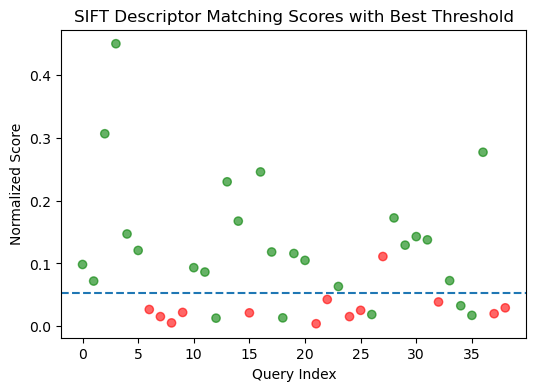

In [13]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# unflaten rates into a single list
predicted_norm_scores_flat = [rate for sublist in rates_csift for rate in sublist]
predicted_norm_scores_flat

# unflaten gt_test into a single list
gt_test_flat = [item for sublist in gt_test for item in sublist]
gt_test_flat

# Inputs you already have
scores = np.array(predicted_norm_scores_flat, dtype=float)
y_true = np.array([0 if gt == -1 else 1 for gt in gt_test_flat], dtype=int)  # 1=known, 0=unknown

# Decide direction automatically: do knowns tend to have higher scores?
mean_known = scores[y_true==1].mean()
mean_unknown = scores[y_true==0].mean()
predict_known_if_higher = mean_known >= mean_unknown   # True -> y_hat = (score >= t), else <=

def preds_from_threshold(th):
    if predict_known_if_higher:
        return (scores >= th).astype(int)
    else:
        return (scores <= th).astype(int)

# Candidate thresholds: midpoints between sorted unique scores + two extremes
uniq = np.unique(scores)
edges = np.concatenate([[uniq.min()-1e-12],
                        (uniq[:-1] + uniq[1:]) / 2.0,
                        [uniq.max()+1e-12]])

best = {
    "threshold": None,
    "f1": -1.0,
    "precision": None,
    "recall": None,
    "accuracy": None
}

for th in edges:
    y_hat = preds_from_threshold(th)
    f1 = f1_score(y_true, y_hat, zero_division=0)
    if f1 > best["f1"]:
        best.update({
            "threshold": th,
            "f1": f1,
            "precision": precision_score(y_true, y_hat, zero_division=0),
            "recall": recall_score(y_true, y_hat, zero_division=0),
            "accuracy": accuracy_score(y_true, y_hat)
        })

side = ">=" if predict_known_if_higher else "<="
print(f"Best threshold: score {side} {best['threshold']:.6f} -> predict KNOWN")
print(f"F1={best['f1']:.3f}  Precision={best['precision']:.3f}  Recall={best['recall']:.3f}  Acc={best['accuracy']:.3f}")

# Optional: plot with decision line
plt.figure(figsize=(6,4))
plt.scatter(range(len(scores)), scores, 
            c=['red' if y==0 else 'green' for y in y_true], alpha=0.6)
plt.axhline(best["threshold"], linestyle='--')
plt.title("SIFT Descriptor Matching Scores with Best Threshold")
plt.xlabel("Query Index")
plt.ylabel("Normalized Score")
plt.show()


In [15]:
# 4) Ranking + mAP
print("🏆 Evaluating retrieval performance...")
pred_csift_orig2, rates_csift2 = compute_matches(
    desc_query_csift,
    db_descs,
    gt_test,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=0.053000,
    # descriptor_type=DESCRIPTOR,
)
map5_csift = mapk(gt_test, pred_csift_orig2,k=5, skip_unknown=False)
map1_csift = mapk(gt_test, pred_csift_orig2, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_csift:.4f}")
print(f"✅ mAP@5 = {map5_csift:.4f}")

🏆 Evaluating retrieval performance...


Processing queries: 100%|██████████| 30/30 [13:15<00:00, 26.51s/it]

Min score for correct matches: 0.011461318051575931
Max score for incorrect matches: 0.1111111111111111
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8333


In [16]:
# save the predicted results to a pickle file in the results/submission folder
# mkdir if not exists
os.makedirs("results/submission", exist_ok=True)
with open(f"results/submission/predicted_test_results_cift_rate042.pkl", "wb") as f:
    pickle.dump(pred_csift_orig, f)
with open(f"results/submission/predicted_test_results_cift_rate053.pkl", "wb") as f:
    pickle.dump(pred_csift_orig2, f)